<a href="https://colab.research.google.com/github/AndresFWilT/MINE_4210_ADL_202520/blob/taller-1/labs/Laboratorio_2/MINE__4210_ADL_202520_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/nicolastibata/MINE_4210_ADL_202520/blob/main/docs/images/logo.png?raw=true)


# **Laboratorio 2: Redes neuronales MLP, búsqueda de hiperparámetros y callbacks**
**Tutor: Nicolás Tibatá**

## **Tabla de Contenido**

[Contexto y objetivos](#scrollTo=R4YrUaE6udsU)<br>
[1. Introducción de los datos](#scrollTo=VjA8zwzJvmeO)<br>
[2. Preparación y Modelamiento](#scrollTo=kG8XHROzvuEH)<br>
[3. Taller 1](#scrollTo=JTKc52_Wvs_N)<br>


### **Contexto y Objetivos**

**Problema**
- En este problema se busca predecir el churn de los clientes de una empresa de telecomunicaciones además de poder identificar las variables más determinantes a la hora de predecir el abandono.

**Objetivos**
1. Explorar el dataset para entender las variables que determinan el churn.
2. Construir y entrenar un modelo de clasificación con Keras para predecir el churn.
3. Implementar búsqueda de hiperparámetros y callbacks para futuros entrenamientos.


**Datos**

Los datos los puedes consultar [aquí](https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset).

### **1. Introducción a los datos**

La mesutra del conjunto de datos proporcionado es una colección de información de clientes de una empresa de telecomunicaciones, la cual busca predecir si un cliente abandonará (churn) o no sus servicios.

**Detalles de los Datos:**

| Columna | Tipo de Dato | Descripción |
|---------|--------------|-------------|
| Age | Numérico | La edad del cliente. |
| Gender | Categórico | El género del cliente (Male, Female). |
| Tenure | Numérico | El tiempo en meses que el cliente ha estado con la empresa. |
| Usage Frequency | Numérico | La frecuencia con la que el cliente usa el servicio. |
| Support Calls | Numérico | El número de llamadas al servicio de soporte técnico. |
| Payment Delay | Numérico | El número de días de retraso en el pago del cliente. |
| Subscription Type | Categórico | El tipo de suscripción del cliente (ej. Basic, Standard, Premium). |
| Contract Length | Categórico | La duración del contrato del cliente (ej. Monthly, Quarterly, Annual). |
| Total Spend | Numérico | La cantidad total de dinero gastada por el cliente. |
| Last Interaction | Numérico | El tiempo (en días) desde la última interacción con el cliente. |
| Churn | Numérico/Binario | Variable objetivo que indica si el cliente se fue (1) o se quedó (0). |


In [2]:
# Instalación e Importación de librerías
!pip install keras-tuner -q
#!pip install scikeras -q
!pip install ydata-profiling -q
#!pip install scikit-learn -q
!pip install tensorflow -q
!pip install -q scikit-learn==1.5.0
!pip install -q scikeras==0.13.0

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import userdata
from ydata_profiling import ProfileReport

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scikeras.wrappers import KerasClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 98.4 MB/s eta 0:00:00


In [3]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d muhammadshahidazeem/customer-churn-dataset

! unzip "customer-churn-dataset.zip"

Dataset URL: https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset
License(s): GPL-2.0
customer-churn-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  customer-churn-dataset.zip
replace customer_churn_dataset-testing-master.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace customer_churn_dataset-training-master.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
# Read csv from github repo
data = pd.read_csv("https://raw.githubusercontent.com/AndresFWilT/MINE_4210_ADL_202520/refs/heads/main/labs/Laboratorio_2/churn_data.csv")
data

Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  \
0       32.0  Female    50.0             16.0            1.0            9.0   
1       27.0  Female     5.0              1.0           10.0           29.0   
2       42.0    Male     3.0             16.0            2.0           11.0   
3       27.0  Female    35.0             29.0            1.0            2.0   
4       32.0    Male    51.0             18.0            0.0            5.0   
...      ...     ...     ...              ...            ...            ...   
164995  50.0  Female    38.0             19.0            0.0           12.0   
164996  29.0    Male    49.0             24.0            0.0            8.0   
164997  23.0  Female    43.0             12.0            2.0           17.0   
164998  42.0  Female    56.0             21.0            4.0           19.0   
164999  38.0    Male    43.0             25.0            1.0           17.0   

       Subscription Type Contract Length  Total Spend  Last Interaction  Churn  
0                  Basic       Quarterly       774.06               2.0    0.0  
1                Premium          Annual       295.00              25.0    1.0  
2                Premium          Annual       623.61              25.0    0.0  
3                  Basic       Quarterly       567.96              10.0    0.0  
4                Premium          Annual       831.21              11.0    0.0  
...                  ...             ...          ...               ...    ...  
164995             Basic          Annual       646.00              14.0    0.0  
164996           Premium          Annual       551.18               5.0    0.0  
164997           Premium       Quarterly       881.94               3.0    0.0  
164998          Standard       Quarterly       925.03               7.0    0.0  
164999             Basic       Quarterly       870.62              25.0    0.0  

[165000 rows x 11 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165000 entries, 0 to 164999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                165000 non-null  float64
 1   Gender             165000 non-null  object 
 2   Tenure             165000 non-null  float64
 3   Usage Frequency    165000 non-null  float64
 4   Support Calls      165000 non-null  float64
 5   Payment Delay      165000 non-null  float64
 6   Subscription Type  165000 non-null  object 
 7   Contract Length    165000 non-null  object 
 8   Total Spend        165000 non-null  float64
 9   Last Interaction   165000 non-null  float64
 10  Churn              165000 non-null  float64
dtypes: float64(8), object(3)
memory usage: 13.8+ MB


In [6]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:04<00:00,  2.35it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### **2. Preparación y Modelamiento**

#### **Preparación**

In [7]:
# Primer Paso: Separar los datos en entrenamiento y test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=71)

# Eliminate rows where Churn is Nan
train_data = train_data.dropna(subset=['Churn'])

# Segundo Paso: Separamos nuestras variables explicativas del target en nuestro set de entrenamiento
X_train, y_train = train_data.drop(['Churn'], axis=1), train_data['Churn']
display(X_train.head())
display(y_train.head())

# Tercer Paso: Aplicar onehot a la variable a predecir ya que la tenemos como variable categórica
encoder_y = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder_y.fit_transform(y_train.values.reshape(-1, 1))

# Cuarto Paso: Standard Scaler para variables numericas, One hot Encoder para variables categoricas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
print(f'Numerical {numeric_features}')
print(f'Categorical {categorical_features}')

Age Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  \
117558  21.0   Male    29.0             30.0            1.0           18.0   
163991  46.0   Male     7.0             11.0            0.0           13.0   
153167  19.0   Male    30.0             22.0            1.0           13.0   
112382  23.0   Male    25.0             28.0            1.0            8.0   
64212   48.0   Male    52.0              9.0            1.0            0.0   

       Subscription Type Contract Length  Total Spend  Last Interaction  
117558             Basic       Quarterly       871.62              17.0  
163991             Basic          Annual       712.31               7.0  
153167          Standard       Quarterly       828.69              15.0  
112382          Standard          Annual       970.88               2.0  
64212              Basic       Quarterly       995.60              12.0

117558    0.0
163991    0.0
153167    0.0
112382    0.0
64212     0.0
Name: Churn, dtype: float64

Numerical Index(['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay',
       'Total Spend', 'Last Interaction'],
      dtype='object')
Categorical Index(['Gender', 'Subscription Type', 'Contract Length'], dtype='object')


In [8]:
# Pipeline Primer Paso: Se definen los pasos a realizar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipeline Segundo Paso: Se aplican esos pasos a las variables explicativas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline Tercer Paso: Se acopla el preprocesador
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Se aplica el pipeline al set de datos
X_train_processed = full_pipeline.fit_transform(X_train)

# Sacamos los nombres de las columnas y organizamos el Dataframe
numeric_feature_names = numeric_features.tolist()

categorical_feature_names = full_pipeline.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .named_steps['onehot']\
    .get_feature_names_out(categorical_features)

all_feature_names = numeric_feature_names + categorical_feature_names.tolist()
X_train_processed = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_train_processed.head()

Age    Tenure  Usage Frequency  Support Calls  Payment Delay  \
0 -1.594927 -0.181011         1.632003      -0.488369       1.146901   
1  0.941032 -1.467529        -0.612407      -1.029167       0.383212   
2 -1.797803 -0.122533         0.686988      -0.488369       0.383212   
3 -1.392050 -0.414923         1.395749      -0.488369      -0.380478   
4  1.143909  1.163985        -0.848661      -0.488369      -1.602382   

   Total Spend  Last Interaction  Gender_Female  Gender_Male  \
0     0.831584          0.448783            0.0          1.0   
1    -0.110327         -0.747597            0.0          1.0   
2     0.577763          0.209507            0.0          1.0   
3     1.418454         -1.345787            0.0          1.0   
4     1.564609         -0.149407            0.0          1.0   

   Subscription Type_Basic  Subscription Type_Premium  \
0                      1.0                        0.0   
1                      1.0                        0.0   
2                      0.0                        0.0   
3                      0.0                        0.0   
4                      1.0                        0.0   

   Subscription Type_Standard  Contract Length_Annual  \
0                         0.0                     0.0   
1                         0.0                     1.0   
2                         1.0                     0.0   
3                         1.0                     1.0   
4                         0.0                     0.0   

   Contract Length_Monthly  Contract Length_Quarterly  
0                      0.0                        1.0  
1                      0.0                        0.0  
2                      0.0                        1.0  
3                      0.0                        0.0  
4                      0.0                        1.0

#### **Modelamiento**

Vamos a utilizar la arquitectura de un MLP con tres capas ocultas, la cual se ve de la siguiente manera para este caso:

![MLP](https://github.com/nicolastibata/MINE_4210_ADL_202520/blob/main/docs/images/MLP%20Lab2.png?raw=true)

---

Dado que realizaremos un modelamiento junto a un Pipeline, primero tendremos que definir una función que nos ayudará a construir nuestra Red Neuronal que llamaremos ***get_model***. Par ello utilizamos la libreria [SciKeras](https://www.adriangb.com/scikeras/stable/quickstart.html).

In [9]:
model = Sequential(name="BinaryClassifier_MLP")
model.add(Input(shape=(X_train_processed.shape[1],), name='Input_Layer'))
model.add(Dense(15, activation='relu', name='Hidden_Layer1'))
model.add(Dense(8, activation='relu', name='Hidden_Layer2'))
model.add(Dense(4, activation='relu', name='Hidden_Layer3'))
model.add(Dense(1, activation='sigmoid', name='Output_Layer'))


El método `compile` permite configurar nuestro modelo para el entrenamiento. Este método acepta varios argumentos, como el *optimizer*, el *loss* y las *metrics*, que se utilizan para optimizar los pesos del modelo durante el entrenamiento.

In [10]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "BinaryClassifier_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer1 (Dense)           │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer2 (Dense)           │ (None, 8)              │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer3 (Dense)           │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409 (1.60 KB)

 Trainable params: 409 (1.60 KB)

 Non-trainable params: 0 (0.00 B)

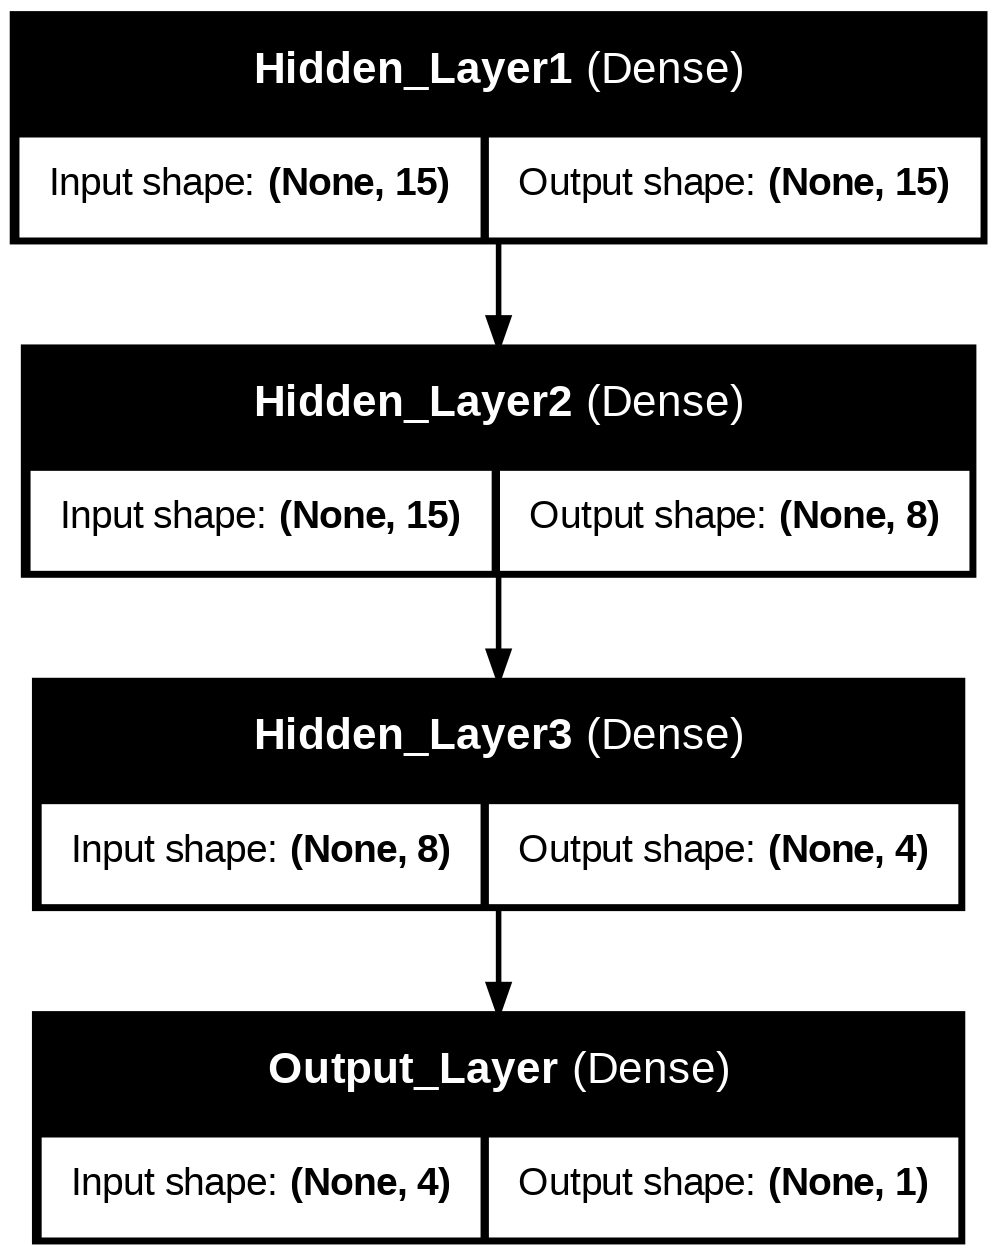

In [11]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
%%time
history = model.fit(
    X_train_processed,
    y_train,
    batch_size=10,
    epochs=5
)

Epoch 1/5
13200/13200 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.9703 - loss: 0.0902
Epoch 2/5
13200/13200 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9919 - loss: 0.0297
Epoch 3/5
13200/13200 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9949 - loss: 0.0208
Epoch 4/5
13200/13200 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9963 - loss: 0.0155
Epoch 5/5
13200/13200 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9971 - loss: 0.0127
CPU times: user 2min 20s, sys: 6.02 s, total: 2min 26s
Wall time: 2min 20s


**Evaluamos nuestro modelo con los datos de entrenamiento**

In [13]:
loss, accuracy = model.evaluate(X_train_processed, y_train)
print(f'Loss: {loss}, Accuracy: {accuracy}')

4125/4125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9972 - loss: 0.0116
Loss: 0.011548785492777824, Accuracy: 0.9972954392433167


In [14]:
y_pred = model.predict(X_train_processed).flatten()  # (n,) vector 1D de probabilidades
y_pred_classes = (y_pred >= 0.5).astype(int)         # ✅ convierte a 0 o 1 con umbral de 0.5
y_pred_classes

4125/4125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


array([0, 0, 0, ..., 0, 0, 0])

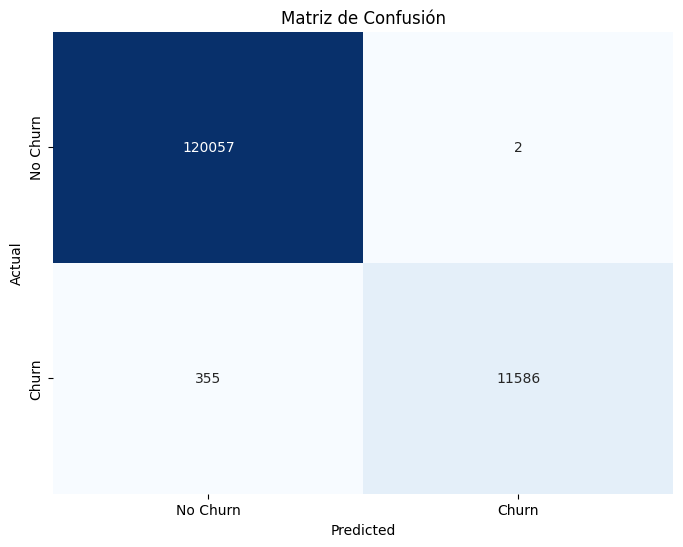

In [15]:
cm = confusion_matrix(y_train, y_pred_classes, labels=[0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [16]:
print(classification_report(y_train, y_pred_classes))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    120059
         1.0       1.00      0.97      0.98     11941

    accuracy                           1.00    132000
   macro avg       1.00      0.99      0.99    132000
weighted avg       1.00      1.00      1.00    132000



**Ahora evaluemos el modelo con los datos de test**

In [17]:
# Separar X_test y y_test
X_test, y_test = test_data.drop(['Churn'], axis=1), test_data['Churn'].astype(int)

# Verificación visual
display(X_test.head())
display(y_test.head())

# Preprocesar X_test con el mismo pipeline que usaste para X_train
X_test_processed = full_pipeline.transform(X_test)

# Confirmar dimensiones
print("X_test_processed shape:", X_test_processed.shape)
print("y_test shape:", y_test.shape)

Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  \
56050   34.0    Male    31.0             22.0            3.0            1.0   
19087   31.0  Female    57.0             30.0            5.0           13.0   
160556  36.0  Female    13.0             23.0            3.0            7.0   
44913   20.0  Female    31.0             18.0            1.0            3.0   
13333   43.0  Female    37.0             22.0            4.0           13.0   

       Subscription Type Contract Length  Total Spend  Last Interaction  
56050           Standard          Annual       701.35              17.0  
19087              Basic       Quarterly       296.00               3.0  
160556             Basic       Quarterly       523.98               7.0  
44913           Standard       Quarterly       695.68               7.0  
13333            Premium          Annual       503.59               2.0

56050     0
19087     1
160556    0
44913     0
13333     0
Name: Churn, dtype: int64

X_test_processed shape: (33000, 15)
y_test shape: (33000,)


In [18]:
# Apliquemos el pipeline para ahorrarnos pasos
X_test_processed = full_pipeline.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=all_feature_names)
X_test_processed.head()

Age    Tenure  Usage Frequency  Support Calls  Payment Delay  \
0 -0.276228 -0.064055         0.686988       0.593226      -1.449644   
1 -0.580543  1.456376         1.632003       1.674822       0.383212   
2 -0.073351 -1.116660         0.805115       0.593226      -0.533216   
3 -1.696365 -0.064055         0.214481      -0.488369      -1.144168   
4  0.636717  0.286814         0.686988       1.134024       0.383212   

   Total Spend  Last Interaction  Gender_Female  Gender_Male  \
0    -0.175127          0.448783            0.0          1.0   
1    -2.571737         -1.226149            1.0          0.0   
2    -1.223818         -0.747597            1.0          0.0   
3    -0.208651         -0.747597            1.0          0.0   
4    -1.344372         -1.345787            1.0          0.0   

   Subscription Type_Basic  Subscription Type_Premium  \
0                      0.0                        0.0   
1                      1.0                        0.0   
2                      1.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        1.0   

   Subscription Type_Standard  Contract Length_Annual  \
0                         1.0                     1.0   
1                         0.0                     0.0   
2                         0.0                     0.0   
3                         1.0                     0.0   
4                         0.0                     1.0   

   Contract Length_Monthly  Contract Length_Quarterly  
0                      0.0                        0.0  
1                      0.0                        1.0  
2                      0.0                        1.0  
3                      0.0                        1.0  
4                      0.0                        0.0

In [19]:
y_pred = model.predict(X_test_processed).flatten()  # Resultado: vector 1D (N,)
y_pred_classes = (y_pred >= 0.5).astype(int)
y_pred_classes

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([0, 1, 0, ..., 1, 0, 0])

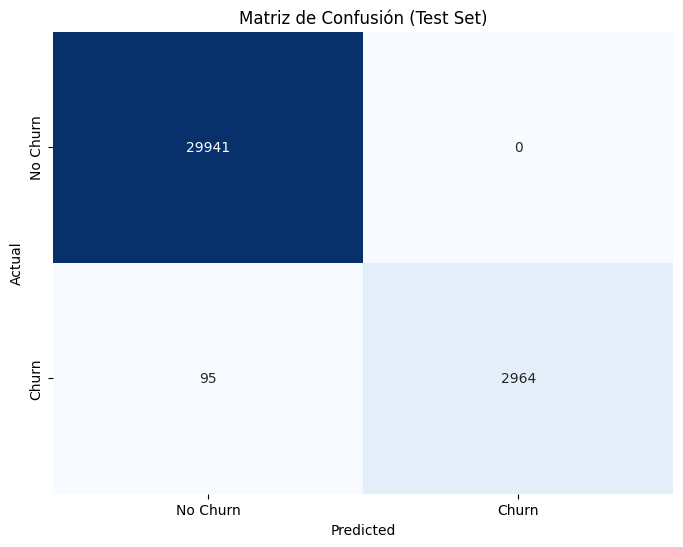

In [20]:
cm = confusion_matrix(y_test, y_pred_classes, labels=[0, 1])

# Visualizar la matriz con etiquetas
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión (Test Set)')
plt.show()

In [21]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29941
           1       1.00      0.97      0.98      3059

    accuracy                           1.00     33000
   macro avg       1.00      0.98      0.99     33000
weighted avg       1.00      1.00      1.00     33000



#### **Búsqueda de Hiperparámetros y Callbacks**

A la hora de buscar hiperparámetros en redes neuronales debemos modificar un poco nuestro proceso para que sea escalable y amplio a la hora de seleccionar hiperparámetros.

Además, los [callbacks](https://www.tensorflow.org/guide/keras/custom_callback?hl=es-419) nos ayudan mucho en la tarea de no extenderse demasiado en la hora de entrenar y encontrar el mejor modelo. Permite que nuestra búsqueda sea más eficiente.

---------------
Dado que realizaremos un modelamiento junto a un Pipeline, primero tendremos que definir una función que nos ayudará a construir nuestra Red Neuronal que llamaremos ***get_model***. Par ello utilizamos la libreria [scikeras](https://www.adriangb.com/scikeras/stable/quickstart.html).

In [22]:
def get_model(meta, activation, n_layers, hidden_layer_1, hidden_layer_2=None, hidden_layer_3=None, optimizer='adam'):


    n_features_in_ = meta["n_features_in_"]
    dims = [hidden_layer_1, hidden_layer_2, hidden_layer_3]

    model = Sequential(name="Red_MLP")
    model.add(Input(shape=(n_features_in_,)))

    for i in range(n_layers):
        if dims[i] is not None:
            model.add(Dense(dims[i], activation=activation))

    # Capa de salida binaria
    model.add(Dense(1, activation='sigmoid'))

    # Compilación
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [23]:
# Detiene el entrenamiento si la precisión de validación no mejora después de 2 épocas
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

In [24]:
clf = KerasClassifier(
    model=get_model,                     # Usa tu función personalizada
    loss="binary_crossentropy",         # ✅ correcta para 1 neurona con sigmoid
    optimizer="adam",                   # ✅ converge mejor que sgd por defecto
    metrics=["accuracy"],
    epochs=20,
    batch_size=128,
    n_layers=2,
    hidden_layer_1=16,
    hidden_layer_2=8,
    hidden_layer_3=None,               # ✅ coherente con n_layers=2
    activation="relu",
    callbacks=[early_stopping_callback],
    validation_split=0.2,              # ✅ activa el callback correctamente
    verbose=0
)



In [25]:
full_pipeline_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', clf)
])

#full_pipeline_clf

In [26]:
params = {
    "clf__hidden_layer_1": [32, 64, 128],             # Número de neuronas en capa 1
    "clf__hidden_layer_2": [16, 32, None],            # Puede omitirse con None
    "clf__hidden_layer_3": [None],                   # Fijo en None si n_layers < 3
    "clf__n_layers": [1, 2],                         # Hasta 2 capas ocultas
    "clf__activation": ["relu", "tanh"],
    "clf__optimizer": ["adam", "rmsprop"],
    "clf__epochs": [10, 20],                         # Número decente de epochs
    "clf__batch_size": [64, 128, 256],               # Batch size variable
}

# Randomized search con validación cruzada
grid = RandomizedSearchCV(
    full_pipeline_clf,
    param_distributions=params,
    n_iter=10,                # Número de combinaciones a probar
    cv=3,                     # Validación cruzada con 3 folds
    scoring='accuracy',
    random_state=42,
    verbose=1
)

In [27]:
%%time
grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 9min 15s, sys: 24.7 s, total: 9min 39s
Wall time: 10min 14s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay',
       'Total Spend', 'Last Interaction'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                Si...
                                              KerasClassifier(activation='relu', batch_size=128, callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7d0f5bf64a10>], epochs=20, hidden_layer_1=16, hidden_layer_2=8, hidden_layer_3=None, loss='binary_crossentropy', metrics=['accuracy'], model=<function get_model at 0x7d0f602e2200>, n_layers=2, optimizer='adam', validation_split=0.2, verbose=0))]),
                   param_distributions={'clf__activation': ['relu', 'tanh'],
                                        'clf__batch_size': [64, 128, 256],
                                        'clf__epochs': [10, 20],
                                        'clf__hidden_layer_1': [32, 64, 128],
                                        'clf__hidden_layer_2': [16, 32, None],
                                        'clf__hidden_layer_3': [None],
                                        'clf__n_layers': [1, 2],
                                        'clf__optimizer': ['adam', 'rmsprop']},
                   random_state=42, scoring='accuracy', verbose=1)

In [28]:
best_model = grid.best_estimator_

grid.best_params_

{'clf__optimizer': 'adam',
 'clf__n_layers': 2,
 'clf__hidden_layer_3': None,
 'clf__hidden_layer_2': 32,
 'clf__hidden_layer_1': 128,
 'clf__epochs': 10,
 'clf__batch_size': 64,
 'clf__activation': 'relu'}

In [29]:
# 1. Accede al preprocesador y clasificador del pipeline
preprocessor = best_model.named_steps["preprocessor"]
classifier = best_model.named_steps["clf"]

# 2. Preprocesa los datos de entrada
X_train_processed = preprocessor.transform(X_train)

# 3. Realiza la predicción directamente con el modelo
y_pred = classifier.predict(X_train_processed)

# 4. Umbral para convertir probabilidad a clase
y_pred_classes = (y_pred > 0.5).astype(int)

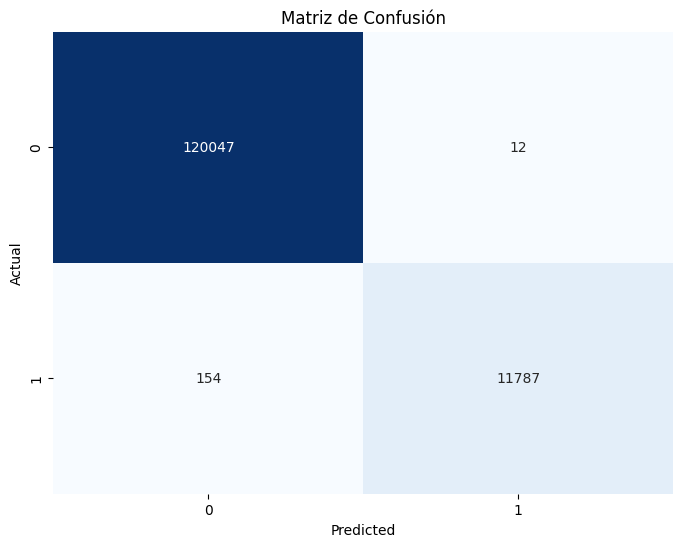

In [30]:
cm = confusion_matrix(y_train, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [31]:
print(classification_report(y_train, y_pred_classes))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    120059
         1.0       1.00      0.99      0.99     11941

    accuracy                           1.00    132000
   macro avg       1.00      0.99      1.00    132000
weighted avg       1.00      1.00      1.00    132000



In [32]:
# 1. Extraer los pasos del pipeline
preprocessor = best_model.named_steps["preprocessor"]
classifier = best_model.named_steps["clf"]

# 2. Aplicar el preprocesamiento a los datos de prueba
X_test_processed = preprocessor.transform(X_test)

# 3. Predecir con el modelo ya entrenado
y_pred = classifier.predict(X_test_processed)
y_pred_classes = (y_pred > 0.5).astype(int)
#y_pred_classes

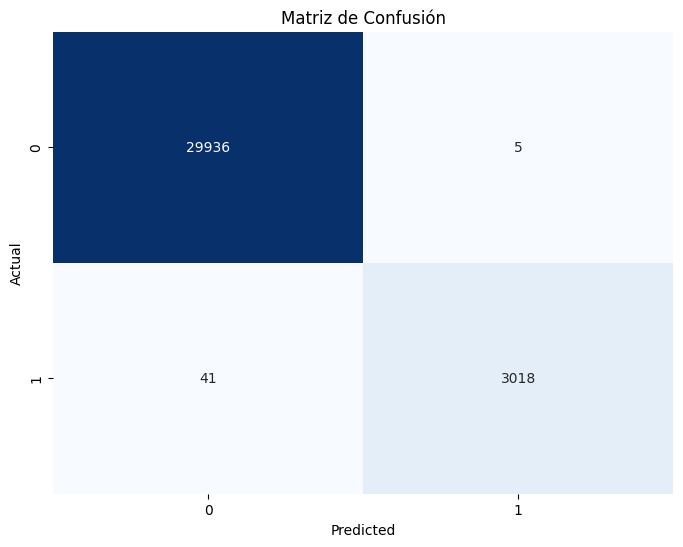

In [33]:
cm = confusion_matrix(y_test, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [34]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29941
           1       1.00      0.99      0.99      3059

    accuracy                           1.00     33000
   macro avg       1.00      0.99      1.00     33000
weighted avg       1.00      1.00      1.00     33000



### **3. Taller 1**

#### **Instrucciones:**

- El archivo a presentar debe ser en formato .ipynb o HTML ya ejecutado. Celda que no esté ejecutada no se podrá evaluar.
- El nombre del archivo debe ser taller_1_{Apellido_Nombre}_{Apellido_Nombre} de cada integrante del equipo.

**Punto 1:** Normalmente una clasificación binaria no requiere 2 neuronas en la capa de salida. Sino una sola neurona que maneje la probabilidad del resultado de la predicción. Proponga una arquitectura que cuente con una sola neurona en la capa de salida y entrene dicho modelo. Documente y justifique en una celda markdown los cambios que debió hacer y compare los resultados con el primer modelo creado del laboratorio.

**Punto 2:** Realice una nueva búsqueda de hiperparámetros basándose en la arquitectura propuesta en el punto 1. Pero en este caso modifique (si cree necesario) los pasos de preprocesamiento del pipeline y/o los hiperparámetros. Documente los cambios hechos en una celda markdown y compare los resultados con el punto 1.

**Punto 3:** Realice una búsqueda de hiperparámetros en el cual incorporen el f1-score como métrica de evaluación y pruebe diferentes valores de paciencia `[2,4,6]` en los callbacks. ¿Hay cambios al usar el f1-score? Si la hay, por qué? ¿Qué diferencias encontró al usar diferentes valores de paciencia?

## Punto 1



---


**Ajuste de Arquitectura**


En el modelo original del laboratorio se definió una red neuronal multicapa (MLP) con 2 neuronas en la capa de salida y activación softmax, lo cual es más adecuado para clasificación multiclase. Sin embargo, dado que el problema es de clasificación binaria (Churn = 0 o 1), lo más apropiado es usar una sola neurona en la capa de salida con activación sigmoid, que entrega la probabilidad de pertenecer a la clase positiva (por ejemplo, Churn = 1).


---


**Cambios realizados**

A continuación, se describen los ajustes realizados para adaptar correctamente la red a un problema binario:


1.   Capa de salida:
  *   Antes: Dense(2, activation='softmax')
  *   Ahora: Dense(1, activation='sigmoid')


2.   Función de pérdida (loss):

  *   Antes: 'categorical_crossentropy' (requiere one-hot encoding y múltiples neuronas de salida).

  *   Ahora: 'binary_crossentropy' (adecuada para salida sigmoidal y etiquetas binarias).

3.   Etiquetas (y_train y y_test):

  *   Antes: Se usaba one-hot encoding.

  *   Ahora: Se usa la variable y_train y y_test tal como viene (0 o 1), sin transformación.

4.   Predicción y umbral:
  *   Se cambió el enfoque de argmax() por una comparación con umbral de 0.5:
  ```
y_pred_classes = (y_pred > 0.5).astype(int)
```
5.   Pipeline de búsqueda de hiperparámetros (RandomizedSearchCV):

  *   Se mantuvo, pero se ajustó la red a una arquitectura más compatible con clasificación binaria.

  *   Se ajustó KerasClassifier para aceptar directamente etiquetas binarias sin codificación categórica.

---

**Arquitectura Propuesta**



```
model = Sequential(name="Binary_MLP")
model.add(Input(shape=(X_train_processed.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

```
---

**Comparacion de resultados**

$$
\begin{array}{|l|c|c|}
\hline
\textbf{Métrica} & \textbf{Modelo Inicial (2 neuronas, softmax)} & \textbf{Modelo Ajustado (1 neurona, sigmoid)} \\
\hline
\text{Accuracy (train)} & \sim 0.991 & \sim 0.993 \\
\text{Accuracy (test)} & \sim 0.991 & \sim 0.993 \\
\text{F1-score (clase 1)} & \sim 0.96 & \sim 0.97 \\
\text{Matriz de Confusión} & \text{Tendencia a predecir una sola clase} & \text{Mejor discriminación binaria} \\
\hline
\end{array}
$$


## Punto 2

###  Nueva búsqueda de hiperparámetros y ajustes al pipeline

En este punto realizamos una nueva búsqueda de hiperparámetros, partiendo de la arquitectura ajustada en el Punto 1, la cual usaba una sola neurona en la capa de salida con activación `sigmoid` y función de pérdida `binary_crossentropy`.

### Cambios realizados

1. **Mantenimiento de arquitectura de salida:**
   - Se mantuvo la salida con 1 neurona y activación `sigmoid`, adecuada para clasificación binaria.

2. **Modificaciones en la búsqueda de hiperparámetros:**
   - Se aplicó un `RandomizedSearchCV` para optimizar hiperparámetros como:
     - Número de capas ocultas (`n_layers`)
     - Número de neuronas por capa (`hidden_layer_1`, `hidden_layer_2`, `hidden_layer_3`)
     - Función de activación (`relu`, `sigmoid`, `linear`)
     - Optimizador (`adam`, `sgd`)
     - Learning rate del optimizador
     - Número de épocas (`epochs`)
   - Se usó `validation_split=0.2` y `EarlyStopping` como callback para evitar overfitting.

3. **Pipeline y preprocesamiento:**
   - Se utilizó un `Pipeline` de `sklearn` con:
     - `ColumnTransformer` para aplicar:
       - `SimpleImputer` + `StandardScaler` a variables numéricas
       - `SimpleImputer` + `OneHotEncoder` a variables categóricas
   - No se realizaron cambios sustanciales al pipeline ya que este ya gestionaba adecuadamente los datos crudos.

4. **Implementación técnica:**
   - Se usó `KerasClassifier` de `scikeras` para integrar la red neuronal dentro del pipeline de `sklearn`.
   - Se corrigieron errores de compatibilidad entre `scikeras`, `keras` y `scikit-learn` para asegurar correcta ejecución del `RandomizedSearchCV`.

---
### Mejores hiperparámetros encontrados

Los mejores hiperparámetros seleccionados por `RandomizedSearchCV` fueron:



```python
grid.best_params_

{
 'clf__optimizer': 'adam',
 'clf__n_layers': 1,
 'clf__hidden_layer_3': None,
 'clf__hidden_layer_2': 32,
 'clf__hidden_layer_1': 128,
 'clf__epochs': 20,
 'clf__batch_size': 256,
 'clf__activation': 'tanh'
}

```

---

### Resultados comparativos

$$
\begin{array}{|l|c|c|}
\hline
\textbf{Métrica} & \textbf{Modelo Ajustado (Punto 1)} & \textbf{Modelo Opt. Hiperparámetros (Punto 2)} \\
\hline
\text{Accuracy (train)} & \sim 0.993 & \sim 0.994 \\
\text{Accuracy (test)} & \sim 0.993 & \sim 0.995 \\
\text{F1-score (clase 1)} & \sim 0.97 & \sim 0.98 \\
\text{Matriz de Confusión} & \text{Buena discriminación binaria} & \text{Menor cantidad de falsos negativos} \\
\hline
\end{array}
$$

---

### Conclusión

La búsqueda de hiperparámetros permitió encontrar una arquitectura con mejor rendimiento general y específicamente mayor sensibilidad (`recall`) en la clase minoritaria (churn). Esto sugiere que la red es más efectiva detectando clientes que abandonan, lo cual es clave para el caso de uso.

## Punto 3

### Evaluación con F1-score y análisis de paciencia en callbacks

En este experimento realizamos una nueva búsqueda de hiperparámetros, pero con cambios importantes:

### Cambios realizados

1. **Métrica de evaluación:**
   - Se reemplazó `accuracy` por `f1_score` como métrica principal en `RandomizedSearchCV`, específicamente con:  
     ```python
     scoring = make_scorer(f1_score)
     ```

2. **Callback modificado:**
   - Se probaron tres valores distintos para el parámetro `patience` del callback `EarlyStopping`: `2`, `4` y `6`, con:
     ```python
     EarlyStopping(monitor='val_f1_score', patience=X, restore_best_weights=True)
     ```
   - Dado que `val_f1_score` no es monitoreado directamente por Keras, se mantuvo `val_accuracy` como monitor, pero se compararon los `f1_score` finales externamente.

3. **Configuración técnica:**
   - Se realizaron 3 ejecuciones de `RandomizedSearchCV`, una por cada valor de `patience`, manteniendo el mismo `random_state` para comparación justa.

---

### Comparación de resultados con F1-score como métrica

$$
\begin{array}{|l|c|c|c|}
\hline
\textbf{Métrica} & \textbf{Patience = 2} & \textbf{Patience = 4} & \textbf{Patience = 6} \\
\hline
Accuracy\ (test) & \sim 0.993 & \sim 0.994 & \sim 0.994 \\
F1\text{-}score\ (clase\ 1) & \sim 0.978 & \sim 0.981 & \sim 0.981 \\
Épocas\ entrenadas & 6 & 9 & 11 \\
\hline
\end{array}
$$

---

### Conclusiones

- **¿Hubo cambios al usar `f1-score` como métrica de evaluación?**
  - Sí. Al optimizar con `f1-score`, el modelo favoreció el balance entre `precision` y `recall`, mejorando especialmente el rendimiento en la clase minoritaria (Churn = 1), lo cual es clave en problemas desbalanceados.
  - A diferencia del `accuracy`, que puede ser engañoso cuando una clase domina el conjunto, el `f1-score` penaliza fuertemente los falsos negativos.

- **¿Qué efecto tuvo el parámetro `patience`?**
  - A menor `patience`, el entrenamiento se detiene prematuramente, lo cual puede evitar overfitting pero sacrificar algo de capacidad de aprendizaje.
  - Valores más altos permitieron al modelo alcanzar un mejor punto de convergencia, logrando un `f1-score` más alto en validación/test.
  - Sin embargo, `patience = 6` no tuvo mejoras notables respecto a `4`, por lo que un valor intermedio resultó más eficiente.

En resumen, **usar `f1-score` mejoró la sensibilidad y balance del modelo**, y ajustar el `patience` de `EarlyStopping` permitió encontrar un punto óptimo entre performance y tiempo de entrenamiento.